<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/En%20Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install shap

In [41]:
import pandas as pd
import numpy as np

#from pandas.core.common import random_state
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
import shap

from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [2]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [3]:
df_original.head()

,Unnamed: 0,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,...,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados,ingreso
0,1,4282.155183,4679.335952,0.000000,0.000000,4923.124484,3918.527125,19692.497937,18439.941778,6653.069810,...,1,0,3,1,0,0,0,63.0,24,31888.466530
1,2,9793.122650,9450.927278,83970.243387,91126.581200,20809.053382,19126.815664,41618.106764,49280.496926,30881.253937,...,0,1,1,1,4,0,2,67.0,24,62341.141710
2,3,531419.701556,512057.084981,0.000000,0.000000,36813.149453,46144.419161,36813.149453,36789.292777,36813.149453,...,2,1,0,3,0,0,0,NaN,24,100599.764680
3,4,0.000000,0.000000,2266.728708,2633.111538,11533.815438,10488.338604,23067.630876,24025.952782,19044.717097,...,4,0,0,4,4,2,3,NaN,24,46102.904895
4,5,112394.057367,110856.020945,0.000000,0.000000,41131.333850,42820.024254,82262.667700,77614.227322,43944.580379,...,4,0,0,4,0,0,0,65.0,14,109419.216020


In [4]:
print (df_original.isnull().sum())

Unnamed: 0                   0
vigente                      0
vigenteAvg3M                 0
vencido                      0
vencidoAvg3M                 0
avgcontingenciaU1M           0
avgcontingenciaU3M           0
sumcontingenciaU1M           0
sumcontingenciaU3M           0
maxcontingenciaU1M           0
maxcontingenciaU3M           0
numcontingenciaU1M           0
garantiacomputable           0
peorcalificacionBCU          0
numeroinstituciones          0
numerobancosprivados         0
numerobancospublicos         0
numerofinancieras            0
numerobancos                 0
numerode5ult18meses          0
numerode2Bult18meses         0
numerode3ult18meses          0
edad                     11429
numeromesesreportados        0
ingreso                      0
dtype: int64


se remplazan los null por la media de la columna

In [3]:
edad_media = df_original['edad'].mean()
edad_media

45.02159532392986

In [4]:
def transfromar_DataFrame (df):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('2B','3').
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  return df

In [5]:
df = transfromar_DataFrame(df_original)


In [8]:
df.head()

,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,maxcontingenciaU3M,...,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados,ingreso
0,4282.155183,4679.335952,0.000000,0.000000,4923.124484,3918.527125,19692.497937,18439.941778,6653.069810,7995.580509,...,1,0,3,1,0,0,0,63.000000,24,31888.466530
1,9793.122650,9450.927278,83970.243387,91126.581200,20809.053382,19126.815664,41618.106764,49280.496926,30881.253937,32793.577625,...,0,1,1,1,4,0,2,67.000000,24,62341.141710
2,531419.701556,512057.084981,0.000000,0.000000,36813.149453,46144.419161,36813.149453,36789.292777,36813.149453,46144.419161,...,2,1,0,3,0,0,0,45.021595,24,100599.764680
3,0.000000,0.000000,2266.728708,2633.111538,11533.815438,10488.338604,23067.630876,24025.952782,19044.717097,17864.388357,...,4,0,0,4,4,2,3,45.021595,24,46102.904895
4,112394.057367,110856.020945,0.000000,0.000000,41131.333850,42820.024254,82262.667700,77614.227322,43944.580379,42820.024254,...,4,0,0,4,0,0,0,65.000000,14,109419.216020


In [6]:
y = df.pop("ingreso")
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [7]:
# La linea base es el promedio de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
media = y_train.mean()
baseline_preds['media'] = media
# Baseline errors, and display average baseline error
baseline_MAPE = MAPE(y_train,baseline_preds['media'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))

MAPE linea base:  58.03


In [8]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = SEED)
# Train the model on training data
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [10]:
# Use the forest's predict method on the test data
preds_rf = rf.predict(X_test)
# Calculate the absolute percentage errors
MAPE_rf = MAPE(y_test, preds_rf)
# Print out the mean absolute percentageerror (mape)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE: 12.92


Text(0.5, 0, 'Xgboost Feature Importance')

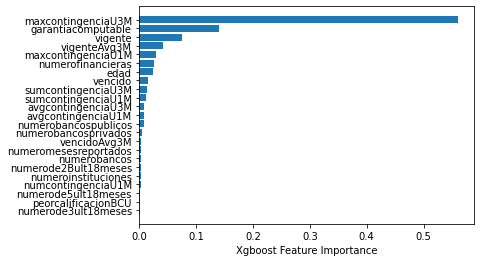

In [11]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), rf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

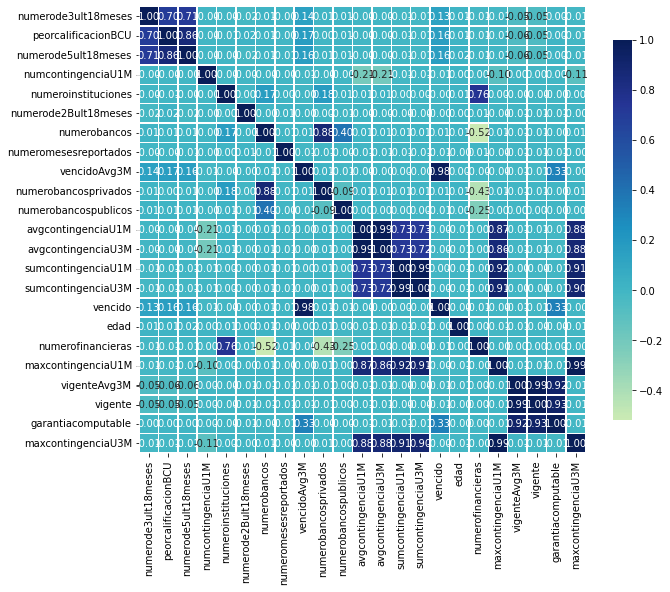

In [12]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[list(X_train.columns[sorted_idx])])

In [15]:
model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="mae",
        #tree_method = "gpu_hist",
        n_estimators=10000,
        random_state=SEED,
        max_depth=6,
        booster="gbtree",
        learning_rate=0.001,
        subsample=0.7,
        gamma=0,
        reg_alpha=0,
        reg_lambda=1,
        importance_type="gain",
        colsample_bytree=0.9,
        colsample_bynode=0.8,
        colsample_bylevel=0.8,
        verbosity=1,
        n_jobs=-1,
)

In [17]:
model.fit(X_train,y_train)

XGBRegressor(colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.9,
             eval_metric='mae', learning_rate=0.001, max_depth=6,
             n_estimators=10000, n_jobs=-1, objective='reg:squarederror',
             random_state=42, subsample=0.7)

In [18]:
preds_xgb = model.predict(X_test)
# Calculate the absolute percentage errors
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 13.47


Text(0.5, 0, 'Xgboost Feature Importance')

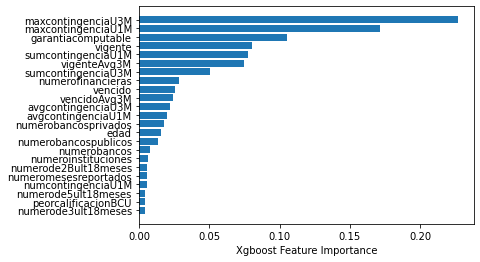

In [33]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

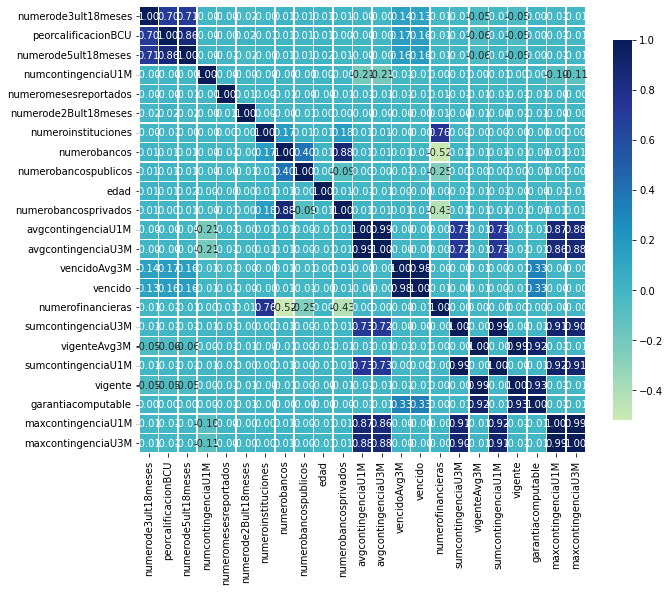

In [34]:
correlation_heatmap(X_train[list(X_train.columns[sorted_idx])])

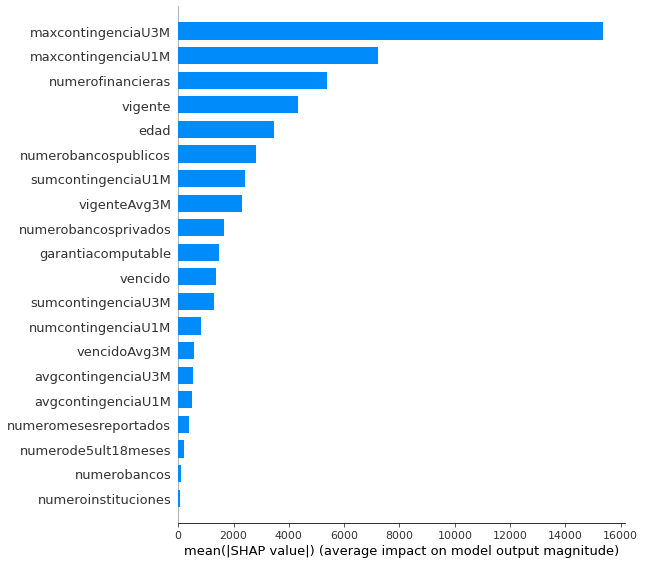

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


Se hace la prueba de una regresión lineal con las columnas más influyentes

In [54]:
X_train_LR = X_train[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]
X_test_LR = X_test[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]

In [55]:
pipe_LR = Pipeline([('scaler',StandardScaler()),('model',LR())])
pipe_LR.fit(X_train_LR,y_train)
preds_LR = pipe_LR.predict(X_test_LR)
MAPE_LR = MAPE(y_test, preds_LR)
print('MAPE_LR:', round(100*MAPE_LR, 2))

MAPE_LR: 19.54


lo mismo con knn

In [57]:
pipe_KNN = Pipeline([('scaler',StandardScaler()),('model',KNN(n_neighbors=5))])
pipe_KNN.fit(X_train_LR,y_train)
preds_KNN = pipe_KNN.predict(X_test_LR)
MAPE_KNN = MAPE(y_test, preds_KNN)
print('MAPE_KNN:', round(100*MAPE_KNN, 2))

MAPE_KNN: 15.42


In [ ]:
#data de test
#url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]
#df_test = pd.read_csv(url)

#df_test.head()